This notebook focuses on using trained model T5-large to incorporate into the existing dataset.This notebook is modification to the existing TREC CAsT number in terms of using the new query rewrite instead of T5-base canard. First we mount the gcs bucket and load the trained model Then we incorporate it into the existing baseline systems.

In [2]:
#Authentication
from google.colab import auth
auth.authenticate_user()

In [3]:
#Installing gcsfuse library
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  66763      0 --:--:-- --:--:-- --:--:-- 66763
OK
37 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.6_amd64.deb ...
Unpacking gcsfuse (0.41.6) ...
Setting up gcsfuse (0.41.6) ...


In [4]:
#Making googlebucketFolder for accessing trecuofg google bucket
!mkdir googleBucketFolder
!gcsfuse --implicit-dirs trecuofg googleBucketFolder

2022/09/09 07:23:47.246249 Start gcsfuse/0.41.6 (Go version go1.18.4) for app "" using mount point: /content/googleBucketFolder
2022/09/09 07:23:47.262527 Opening GCS connection...
2022/09/09 07:23:47.963817 Mounting file system "trecuofg"...
2022/09/09 07:23:47.964466 File system has been successfully mounted.


In [5]:
# install dependencies
!pip install pyserini==0.16.0
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84.6 MB 195 kB/s 
     |████████████████████████████████| 13.5 MB 51.3 MB/s 
     |████████████████████████████████| 4.9 MB 32.5 MB/s 
     |████████████████████████████████| 2.0 MB 53.2 MB/s 
     |████████████████████████████████| 1.3 MB 55.3 MB/s 
     |████████████████████████████████| 188 kB 39.0 MB/s 
     |████████████████████████████████| 15.7 MB 88 kB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
ERROR: pip's dependency resolver does not currently take into account al

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 4.1 MB/s 


In [7]:
#Initialzing Pyserini searcher
from pyserini.search.lucene import LuceneSearcher
sparse_searcher = LuceneSearcher("googleBucketFolder/sparse")


## Importing and evaluating the trained model

In [1]:
print("Installing dependencies...")
%tensorflow_version 2.x
!pip install -q t5
!pip install -q t5 tensorflow-text==2.2.
!pip install -U tensorflow-gcs-config==2.1.3
!pip install tensorflow_io-gcs-config==0.23.1
!pip install tensorflow==2.3 t5 tensorflow-text==2.3
#%env USE_AUTH_EPHEM=0
import functools
import os
import sys
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds

import t5
import t5.models
import seqio




Installing dependencies...
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     |████████████████████████████████| 153 kB 4.3 MB/s 
     |████████████████████████████████| 4.7 MB 46.4 MB/s 
     |████████████████████████████████| 4.7 MB 43.4 MB/s 
     |████████████████████████████████| 311 kB 46.9 MB/s 
     |████████████████████████████████| 1.3 MB 32.9 MB/s 
     |████████████████████████████████| 116 kB 63.1 MB/s 
     |████████████████████████████████| 385 kB 50.9 MB/s 
     |████████████████████████████████| 5.9 MB 33.1 MB/s 
     |████████████████████████████████| 120 kB 37.2 MB/s 
     |████████████████████████████████| 6.6 MB 32.4 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 438 kB 66.3 MB/s 
     |████████████████████████████████| 1.7 MB 38.3 MB/s 
     |████████████████████████████████| 5.9 MB 48.7 MB/s 
     |████████████████████████████████| 3.0 MB 4.3 MB/s 
     |████████████████████████████

In [6]:
#Importing the model from GCS
import tensorflow as tf
import tensorflow_text  # Required to run exported model.

# TODO change this to load a different model
saved_model_path = "googleBucketFolder/models/large_temperature_0/export/1660202739"

def load_predict_fn(model_path):
  if tf.executing_eagerly():
    print("Loading SavedModel in eager mode.")
    imported = tf.saved_model.load(model_path, ["serve"])
    return lambda x: imported.signatures['serving_default'](tf.constant(x))['outputs'].numpy()
  else:
    print("Loading SavedModel in tf 1.x graph mode.")
    tf.compat.v1.reset_default_graph()
    sess = tf.compat.v1.Session()
    meta_graph_def = tf.compat.v1.saved_model.load(sess, ["serve"], model_path)
    signature_def = meta_graph_def.signature_def["serving_default"]
    return lambda x: sess.run(
        fetches=signature_def.outputs["outputs"].name, 
        feed_dict={signature_def.inputs["input"].name: x}
    )

predict_fn = load_predict_fn(saved_model_path)

Loading SavedModel in eager mode.


In [8]:
#rewriting the mdoel
def answer(question):
  return predict_fn([question])[0].decode('utf-8')

In [9]:
#Downloading manual evaluation topic from TREC CAsT tools
!echo "Downloading Year 3 beanchmark.."
!wget -c https://raw.githubusercontent.com/daltonj/treccastweb/master/2021/2021_manual_evaluation_topics_v1.0.json -P files



--2022-09-09 07:29:11--  https://raw.githubusercontent.com/daltonj/treccastweb/master/2021/2021_manual_evaluation_topics_v1.0.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364897 (356K) [text/plain]
Saving to: ‘files/2021_manual_evaluation_topics_v1.0.json’

2021_manual_evaluat 100%[===================>] 356.34K  --.-KB/s    in 0.04s   

2022-09-09 07:29:11 (8.83 MB/s) - ‘files/2021_manual_evaluation_topics_v1.0.json’ saved [364897/364897]



In [10]:
#Checking the topics
import json

with open("files/2021_manual_evaluation_topics_v1.0.json") as cast_topics_file:
  topics = json.load(cast_topics_file)
  for topic in topics:
    print(f"Topic {topic['number']}")
    print("\n")
    for turn in topic['turn']:
      print(f"Turn {turn['number']}: {turn['raw_utterance']}")
      print(f"System Response: {turn['passage']}")
      print("\n")

Topic 106


Turn 1: I just had a breast biopsy for cancer. What are the most common types?
System Response: More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out.


Turn 2: Once it breaks out, how likely is it to spread?
System Response: Even though this condition doesn’t spread, it’s important to keep an eye on it. Between 20% to 40% of women with this condition will develop a separate invasive breast cancer -- one that will grow outside its original location -- within the next 15 years. Most of the time, these later cancers begin in the milk ducts, rather than the lobules. How is lobu

## Building Context and rewritng

In [11]:
# Getting turn attributes based on topic,id and type of utterance
def get_turn_attribute(topics: list, global_turn_id: str, attribute: str) -> str:
  """
  Returns topic and turn attributes
  """
  first_topic_number = 106
  topic_number, turn_number = global_turn_id.strip().split("_")

  # Get topic
  topic_index = int(topic_number) - first_topic_number
  topic = topics[topic_index]

  turn_index = int(turn_number) - 1
  extracted_attribute = topic['turn'][turn_index][attribute]

  return topic, turn_index, extracted_attribute

#Building the context as required for the new model which Query [CTX] every [TURN]
def build_context(topics: list, global_turn_id: str) -> str:
  """
  Given a global_turn_id, build rewriter model input (context)
  with all previous turn utterances and system responses
  """
  topic, turn_index, current_turn_utterance = get_turn_attribute(
      topics, global_turn_id, 'raw_utterance'
  )


  previous_turn_context = [f"{turn['raw_utterance']} [TURN] {turn['passage']}" for turn in topic['turn'][:turn_index]]
  previous_turn_context = (" [TURN] ").join(previous_turn_context)

  return f"{current_turn_utterance} [CTX] {previous_turn_context} "
  

In [12]:
#Using rogue score to calculate quality of all rewrites
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd
turn_id_arr=[]
rogue1_precision=[]
rogue1_recall=[]
rogue1_fmeasure =[]

rogue2_precision = []
rogue2_recall = []
rogue2_fmeasure = []

roguel_precision = []
roguel_recall = []
roguel_fmeasure = []
for topic in topics:
  for turn in topic['turn']:
    # get turn id

    turn_id = f"{topic['number']}_{turn['number']}"
    print(turn_id)
    turn_id_arr.append(turn_id)
    # Build rewriter input -- not ideal, but saves having to write logic again
    query_and_context = build_context(topics, turn_id)
    print(query_and_context)
    # rewrite query
    _, _, raw_utterance = get_turn_attribute(topics, turn_id, 'raw_utterance')
    print(f"Raw utterance: {raw_utterance}")
    _, _, manual_rewritten_utterance = get_turn_attribute(topics, turn_id, 'automatic_rewritten_utterance')
    print(f"Manual Rewritten Utterance: {manual_rewritten_utterance}")
    rewrite = answer("canard context: " + query_and_context)
    print("Rewrite" + rewrite)
    #break
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(rewrite, manual_rewritten_utterance)
    #print(scores)
    rogue1_precision.append(scores['rouge1'].precision)
    rogue1_recall.append(scores['rouge1'].recall)
    rogue1_fmeasure.append(scores['rouge1'].fmeasure)

    rogue2_precision.append(scores['rouge2'].precision)
    rogue2_recall.append(scores['rouge2'].recall)
    rogue2_fmeasure.append(scores['rouge2'].fmeasure)


    roguel_precision.append(scores['rougeL'].precision)
    roguel_recall.append(scores['rougeL'].recall)
    roguel_fmeasure.append(scores['rougeL'].fmeasure)


    rogue1_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue1_precision,'Recall':rogue1_recall,'Fmeasure':rogue1_fmeasure})
    rogue2_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue2_precision,'Recall':rogue2_recall,'Fmeasure':rogue2_fmeasure})
    roguel_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':roguel_precision,'Recall':roguel_recall,'Fmeasure':roguel_fmeasure})



    

106_1
I just had a breast biopsy for cancer. What are the most common types? [CTX]  
Raw utterance: I just had a breast biopsy for cancer. What are the most common types?
Manual Rewritten Utterance: What are the most common types of cancer in regards to breast biopsy?
RewriteI just had a breast biopsy for cancer. What are the most common types?
106_2
Once it breaks out, how likely is it to spread? [CTX] I just had a breast biopsy for cancer. What are the most common types? [TURN] More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out. 
Raw utterance: Once it breaks out, how likely is it 

In [13]:
rogue1_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.692308,0.642857,0.666667
1,106_2,0.909091,0.909091,0.909091
2,106_3,0.750000,0.428571,0.545455
3,106_4,0.888889,0.571429,0.695652
4,106_5,0.555556,0.357143,0.434783
...,...,...,...,...
234,131_6,1.000000,1.000000,1.000000
235,131_7,0.857143,0.857143,0.857143
236,131_8,0.818182,0.692308,0.750000
237,131_9,1.000000,1.000000,1.000000


In [14]:
rogue2_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.500000,0.461538,0.480000
1,106_2,0.800000,0.800000,0.800000
2,106_3,0.666667,0.333333,0.444444
3,106_4,0.750000,0.461538,0.571429
4,106_5,0.500000,0.307692,0.380952
...,...,...,...,...
234,131_6,1.000000,1.000000,1.000000
235,131_7,0.666667,0.666667,0.666667
236,131_8,0.800000,0.666667,0.727273
237,131_9,1.000000,1.000000,1.000000


In [15]:
roguel_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.461538,0.428571,0.444444
1,106_2,0.909091,0.909091,0.909091
2,106_3,0.750000,0.428571,0.545455
3,106_4,0.888889,0.571429,0.695652
4,106_5,0.555556,0.357143,0.434783
...,...,...,...,...
234,131_6,1.000000,1.000000,1.000000
235,131_7,0.857143,0.857143,0.857143
236,131_8,0.818182,0.692308,0.750000
237,131_9,1.000000,1.000000,1.000000


In [16]:
from google.colab import files
import pandas as pd
rogue1_scores.to_csv('rogue1_scores_automatic.csv')
files.download('rogue1_scores_automatic.csv')

rogue2_scores.to_csv('rogue2_scores_automatic.csv')
files.download('rogue2_scores_automatic.csv')

roguel_scores.to_csv('roguel_scores_automatic.csv')
files.download('roguel_scores_automatic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#rogue 1 Raw Utterance
rogue1_raw_utterances = rogue1_scores

In [19]:
#Printing out total number of values less than 50%
rogue1_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].shape

(22, 4)

In [20]:
#Storing it in an array
Incorrect_writes_1 = rogue1_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [21]:
Incorrect_writes_1.head(25)

,turn_id,Precison,Recall,Fmeasure
75,113_11,0.000000,0.000000,0.000000
172,124_5,0.000000,0.000000,0.000000
131,119_5,0.111111,0.066667,0.083333
175,124_8,0.125000,0.166667,0.142857
111,117_6,0.153846,0.400000,0.222222
113,117_8,0.200000,0.100000,0.133333
71,113_7,0.200000,0.111111,0.142857
166,123_8,0.250000,0.285714,0.266667
140,120_5,0.294118,0.714286,0.416667
60,112_7,0.333333,0.500000,0.400000


In [22]:
rogue2_raw_utterances = rogue2_scores

In [23]:
#Printing out total values less than 50%
rogue2_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].shape

(22, 4)

In [29]:
Incorrect_writes_2 = rogue2_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [30]:
Incorrect_writes_2.head(25)

,turn_id,Precison,Recall,Fmeasure
113,117_8,0.000000,0.000000,0.000000
175,124_8,0.000000,0.000000,0.000000
71,113_7,0.000000,0.000000,0.000000
75,113_11,0.000000,0.000000,0.000000
172,124_5,0.000000,0.000000,0.000000
166,123_8,0.000000,0.000000,0.000000
195,127_5,0.000000,0.000000,0.000000
131,119_5,0.000000,0.000000,0.000000
111,117_6,0.040000,0.111111,0.058824
60,112_7,0.090909,0.142857,0.111111


In [24]:
rogueL_raw_utterances = roguel_scores

In [25]:
rogueL_raw_utterances[rogueL_raw_utterances['Precison'] < 0.5].shape

(30, 4)

In [26]:
Incorrect_writes_L = rogueL_raw_utterances[rogueL_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [27]:
Incorrect_writes_L.head(25)

,turn_id,Precison,Recall,Fmeasure
172,124_5,0.000000,0.000000,0.000000
75,113_11,0.000000,0.000000,0.000000
131,119_5,0.111111,0.066667,0.083333
175,124_8,0.125000,0.166667,0.142857
111,117_6,0.153846,0.400000,0.222222
71,113_7,0.200000,0.111111,0.142857
113,117_8,0.200000,0.100000,0.133333
195,127_5,0.230769,0.176471,0.200000
166,123_8,0.250000,0.285714,0.266667
137,120_2,0.285714,0.400000,0.333333


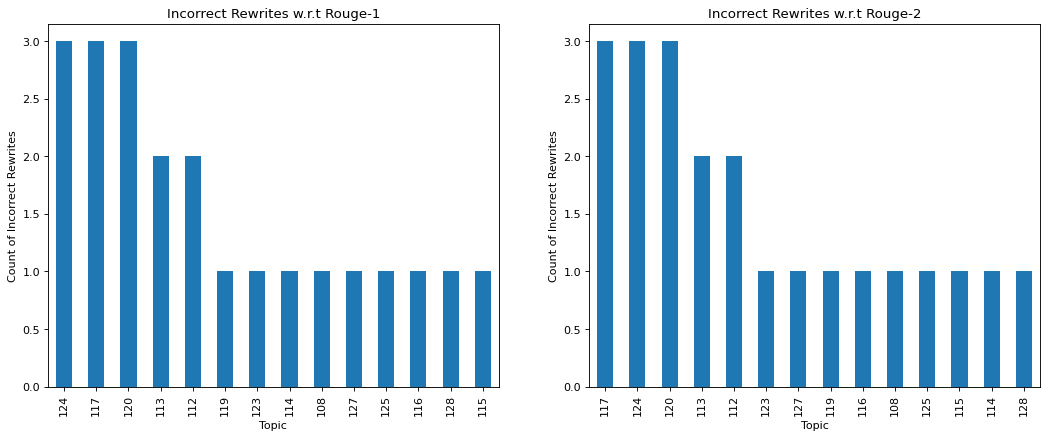

In [31]:
#barplots of every topic for rouge 1 and rouge 2
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6), dpi=80)
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-1")
Incorrect_writes_1['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.subplot(rows, cols, 2)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-2")
Incorrect_writes_2['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

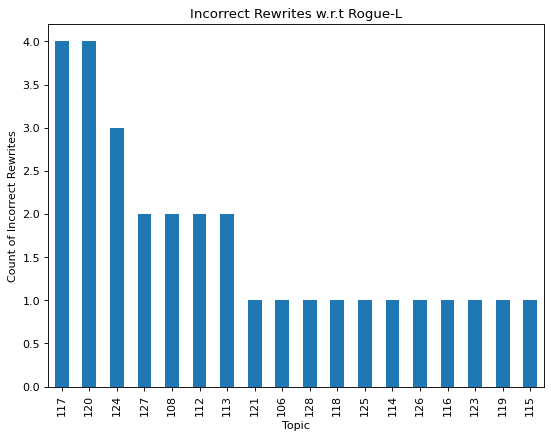

In [32]:
#barplots of every topic for rougel scores
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rogue-L")
Incorrect_writes_L['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

In [33]:
#Getting turns 
rogueL_raw_utterances['ID'] = rogueL_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]
rogue2_raw_utterances['ID'] = rogue2_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]
rogue1_raw_utterances['ID'] = rogue2_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


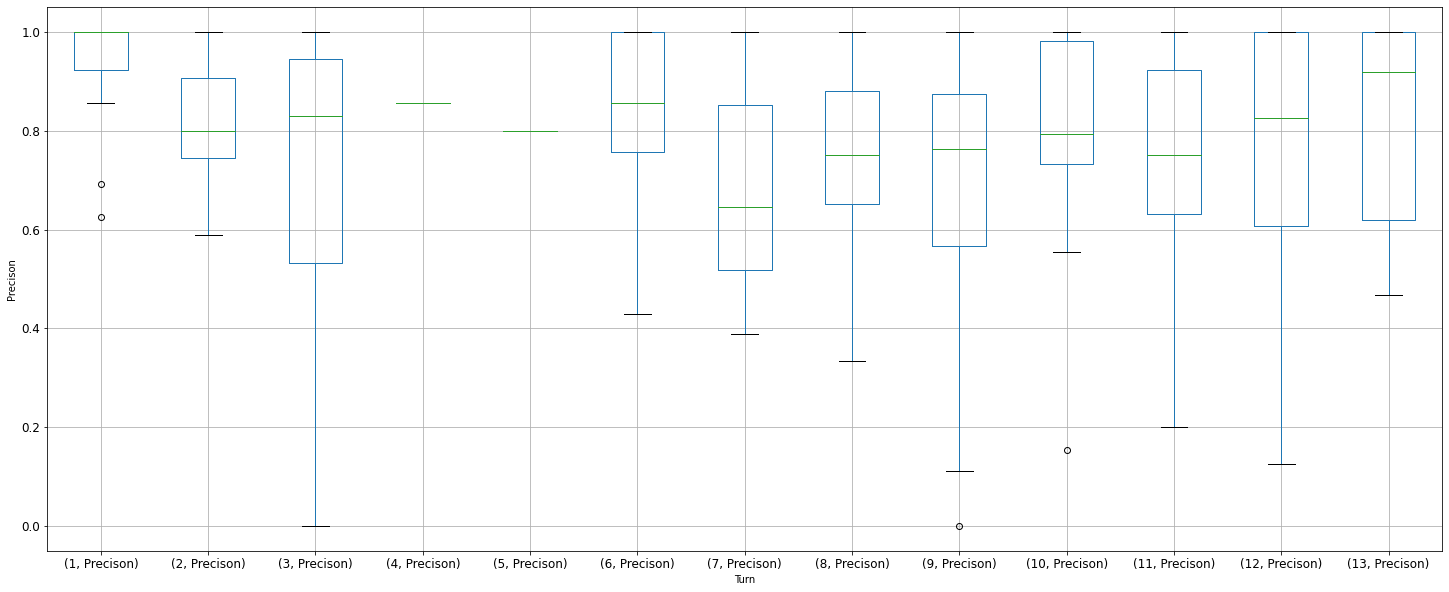

In [34]:
#boxplot for turns
import matplotlib.pyplot as plt
rogue_1_precison = rogue1_raw_utterances[['Precison','ID']]
df_groups = rogue_1_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


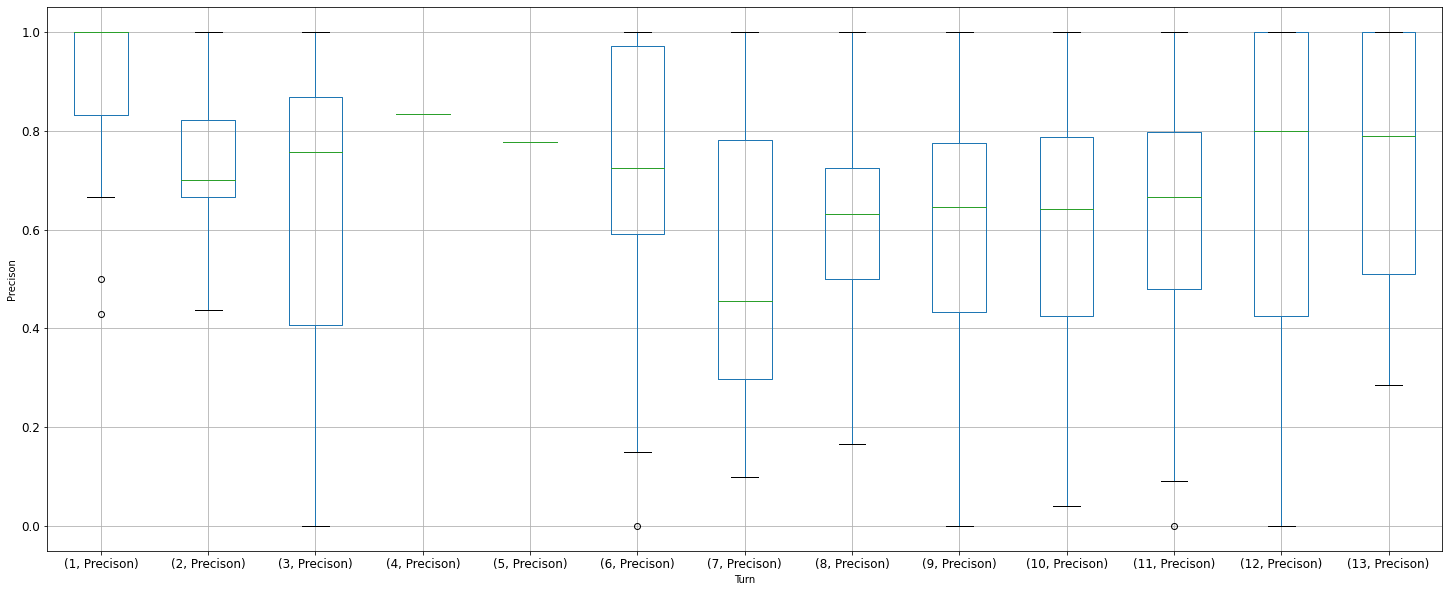

In [35]:
#boxplots for turns
import matplotlib.pyplot as plt

rogue_2_precison = rogue2_raw_utterances[['Precison','ID']]
df_groups = rogue_2_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


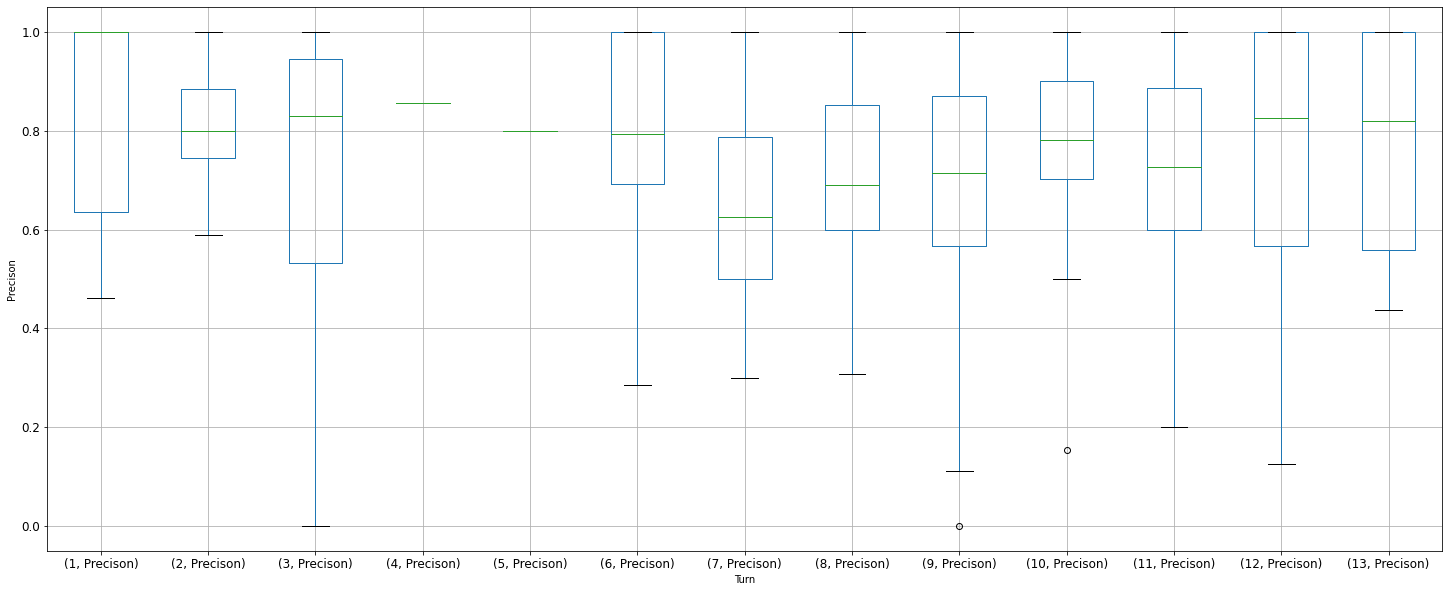

In [36]:
#boxplots for turns
import matplotlib.pyplot as plt
#calculate sum of points for each team
rogue_L_precison = rogueL_raw_utterances[['Precison','ID']]
df_groups = rogue_L_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

In [37]:
#Using rogue score to calculate quality of all rewrites
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd
turn_id_arr=[]
rogue1_precision=[]
rogue1_recall=[]
rogue1_fmeasure =[]

rogue2_precision = []
rogue2_recall = []
rogue2_fmeasure = []

roguel_precision = []
roguel_recall = []
roguel_fmeasure = []
for topic in topics:
  for turn in topic['turn']:
    # get turn id

    turn_id = f"{topic['number']}_{turn['number']}"
    print(turn_id)
    turn_id_arr.append(turn_id)
    # Build rewriter input -- not ideal, but saves having to write logic again
    query_and_context = build_context(topics, turn_id)
    print(query_and_context)
    # rewrite query
    _, _, raw_utterance = get_turn_attribute(topics, turn_id, 'raw_utterance')
    print(f"Raw utterance: {raw_utterance}")
    _, _, manual_rewritten_utterance = get_turn_attribute(topics, turn_id, 'manual_rewritten_utterance')
    print(f"Manual Rewritten Utterance: {manual_rewritten_utterance}")
    rewrite = answer("canard context: " + query_and_context)
    print("Rewrite" + rewrite)
    #break
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(rewrite, manual_rewritten_utterance)
    #print(scores)
    rogue1_precision.append(scores['rouge1'].precision)
    rogue1_recall.append(scores['rouge1'].recall)
    rogue1_fmeasure.append(scores['rouge1'].fmeasure)

    rogue2_precision.append(scores['rouge2'].precision)
    rogue2_recall.append(scores['rouge2'].recall)
    rogue2_fmeasure.append(scores['rouge2'].fmeasure)


    roguel_precision.append(scores['rougeL'].precision)
    roguel_recall.append(scores['rougeL'].recall)
    roguel_fmeasure.append(scores['rougeL'].fmeasure)


    rogue1_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue1_precision,'Recall':rogue1_recall,'Fmeasure':rogue1_fmeasure})
    rogue2_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue2_precision,'Recall':rogue2_recall,'Fmeasure':rogue2_fmeasure})
    roguel_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':roguel_precision,'Recall':roguel_recall,'Fmeasure':roguel_fmeasure})



    

106_1
I just had a breast biopsy for cancer. What are the most common types? [CTX]  
Raw utterance: I just had a breast biopsy for cancer. What are the most common types?
Manual Rewritten Utterance: I just had a breast biopsy for cancer. What are the most common types of breast cancer?
RewriteI just had a breast biopsy for cancer. What are the most common types?
106_2
Once it breaks out, how likely is it to spread? [CTX] I just had a breast biopsy for cancer. What are the most common types? [TURN] More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out. 
Raw utterance: Once it breaks out,

In [38]:
rogue1_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.823529,1.000000,0.903226
1,106_2,0.846154,1.000000,0.916667
2,106_3,1.000000,1.000000,1.000000
3,106_4,1.000000,1.000000,1.000000
4,106_5,0.750000,0.857143,0.800000
...,...,...,...,...
234,131_6,0.933333,1.000000,0.965517
235,131_7,0.636364,1.000000,0.777778
236,131_8,0.857143,0.923077,0.888889
237,131_9,1.000000,1.000000,1.000000


In [39]:
rogue2_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.812500,1.000000,0.896552
1,106_2,0.500000,0.600000,0.545455
2,106_3,1.000000,1.000000,1.000000
3,106_4,1.000000,1.000000,1.000000
4,106_5,0.733333,0.846154,0.785714
...,...,...,...,...
234,131_6,0.857143,0.923077,0.888889
235,131_7,0.500000,0.833333,0.625000
236,131_8,0.846154,0.916667,0.880000
237,131_9,1.000000,1.000000,1.000000


In [40]:
roguel_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.823529,1.000000,0.903226
1,106_2,0.615385,0.727273,0.666667
2,106_3,1.000000,1.000000,1.000000
3,106_4,1.000000,1.000000,1.000000
4,106_5,0.750000,0.857143,0.800000
...,...,...,...,...
234,131_6,0.933333,1.000000,0.965517
235,131_7,0.636364,1.000000,0.777778
236,131_8,0.857143,0.923077,0.888889
237,131_9,1.000000,1.000000,1.000000


In [41]:
from google.colab import files
import pandas as pd
rogue1_scores.to_csv('rogue1_scores_manual.csv')
files.download('rogue1_scores_manual.csv')

rogue2_scores.to_csv('rogue2_scores_manual.csv')
files.download('rogue2_scores_manual.csv')

roguel_scores.to_csv('roguel_scores_manual.csv')
files.download('roguel_scores_manual.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
#rogue 1 Raw Utterance
rogue1_raw_utterances = rogue1_scores

In [43]:
#Printing out total number of values less than 50%
rogue1_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].shape

(44, 4)

In [44]:
#Storing it in an array
Incorrect_writes_1 = rogue1_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [45]:
Incorrect_writes_1.head(25)

,turn_id,Precison,Recall,Fmeasure
75,113_11,0.000000,0.000000,0.000000
175,124_8,0.142857,0.166667,0.153846
71,113_7,0.176471,0.333333,0.230769
35,110_3,0.214286,1.000000,0.352941
40,110_8,0.222222,0.250000,0.235294
20,108_3,0.250000,0.571429,0.347826
70,113_6,0.250000,0.363636,0.296296
46,111_4,0.250000,0.400000,0.307692
64,112_11,0.250000,0.307692,0.275862
16,107_7,0.250000,0.500000,0.333333


In [46]:
rogue2_raw_utterances = rogue2_scores

In [47]:
#Printing out total values less than 50%
rogue2_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].shape

(44, 4)

In [48]:
Incorrect_writes_2 = rogue2_raw_utterances[rogue1_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [49]:
Incorrect_writes_2.head(25)

,turn_id,Precison,Recall,Fmeasure
35,110_3,0.000000,0.000000,0.000000
195,127_5,0.000000,0.000000,0.000000
111,117_6,0.000000,0.000000,0.000000
60,112_7,0.000000,0.000000,0.000000
40,110_8,0.000000,0.000000,0.000000
71,113_7,0.000000,0.000000,0.000000
75,113_11,0.000000,0.000000,0.000000
175,124_8,0.000000,0.000000,0.000000
190,126_6,0.000000,0.000000,0.000000
64,112_11,0.066667,0.083333,0.074074


In [50]:
rogueL_raw_utterances = roguel_scores

In [51]:
rogueL_raw_utterances[rogueL_raw_utterances['Precison'] < 0.5].shape

(50, 4)

In [52]:
Incorrect_writes_L = rogueL_raw_utterances[rogueL_raw_utterances['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [53]:
Incorrect_writes_L.head(25)

,turn_id,Precison,Recall,Fmeasure
75,113_11,0.000000,0.000000,0.000000
40,110_8,0.111111,0.125000,0.117647
175,124_8,0.142857,0.166667,0.153846
71,113_7,0.176471,0.333333,0.230769
64,112_11,0.187500,0.230769,0.206897
131,119_5,0.210526,0.266667,0.235294
35,110_3,0.214286,1.000000,0.352941
24,108_7,0.222222,0.285714,0.250000
16,107_7,0.250000,0.500000,0.333333
20,108_3,0.250000,0.571429,0.347826


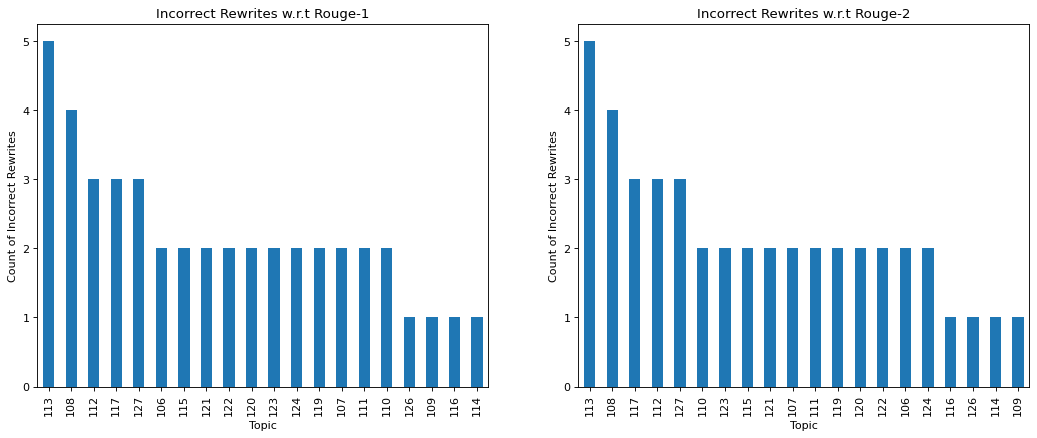

In [54]:
#barplots of every topic for rouge 1 and rouge 2
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6), dpi=80)
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-1")
Incorrect_writes_1['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.subplot(rows, cols, 2)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-2")
Incorrect_writes_2['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

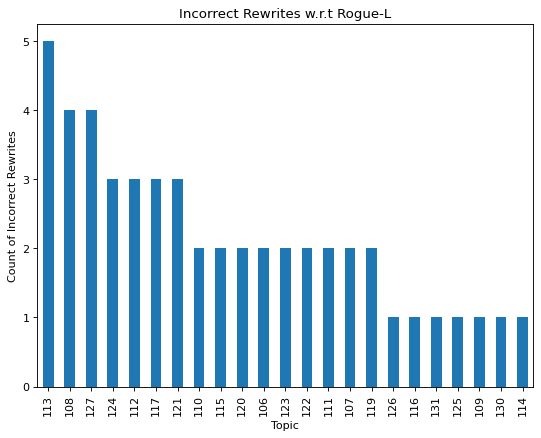

In [55]:
#barplots of every topic for rougel scores
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rogue-L")
Incorrect_writes_L['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

In [56]:
#Getting turns 
rogueL_raw_utterances['ID'] = rogueL_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]
rogue2_raw_utterances['ID'] = rogue2_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]
rogue1_raw_utterances['ID'] = rogue2_raw_utterances['turn_id'].str.split('_',n=-1, expand=True)[1]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


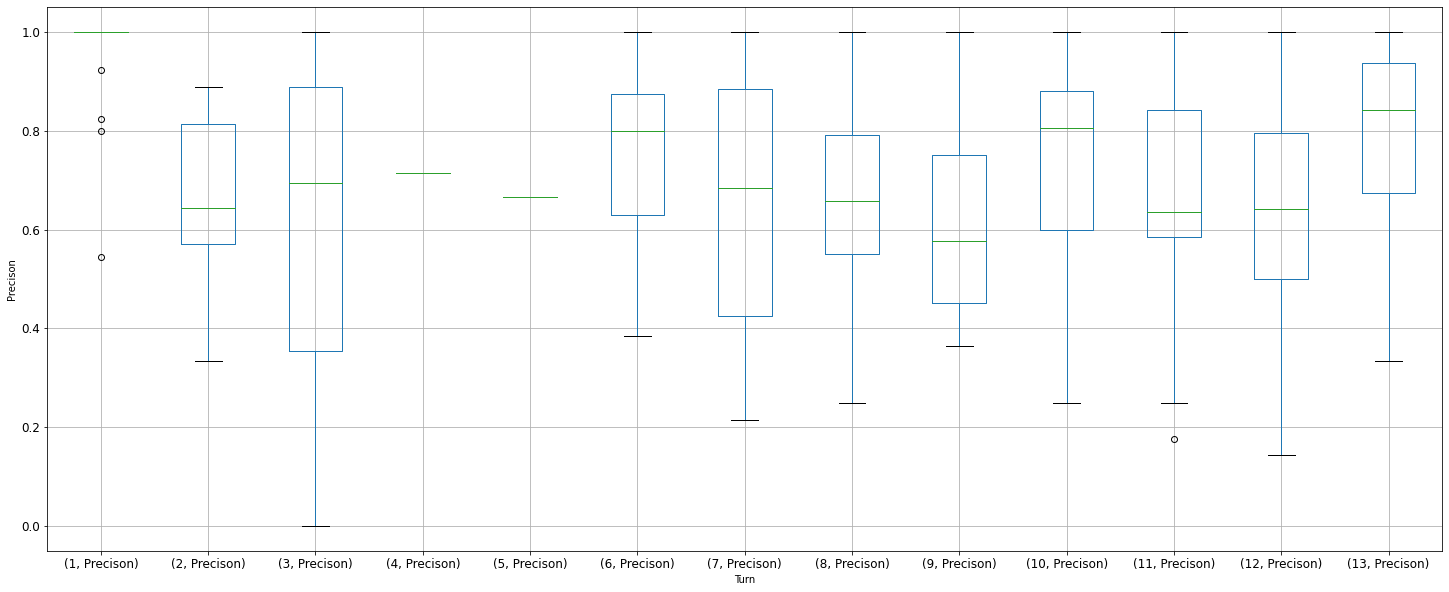

In [57]:
#boxplot for turns
import matplotlib.pyplot as plt
rogue_1_precison = rogue1_raw_utterances[['Precison','ID']]
df_groups = rogue_1_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


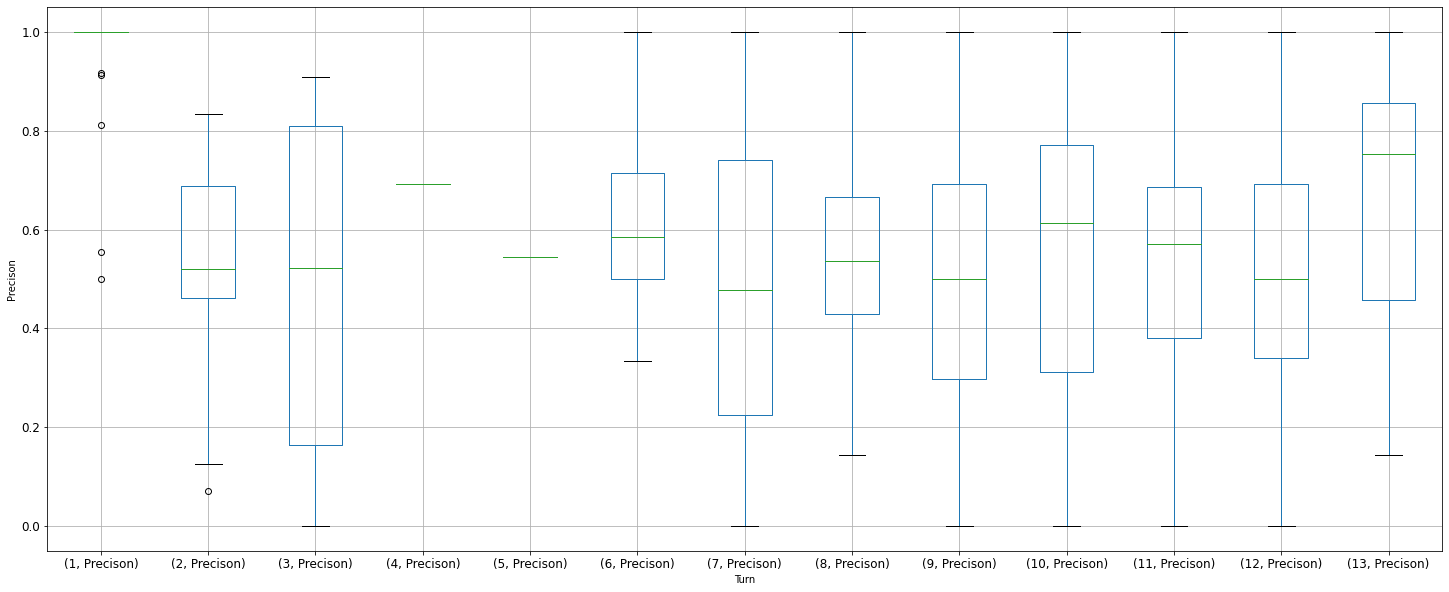

In [58]:
#boxplots for turns
import matplotlib.pyplot as plt

rogue_2_precison = rogue2_raw_utterances[['Precison','ID']]
df_groups = rogue_2_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


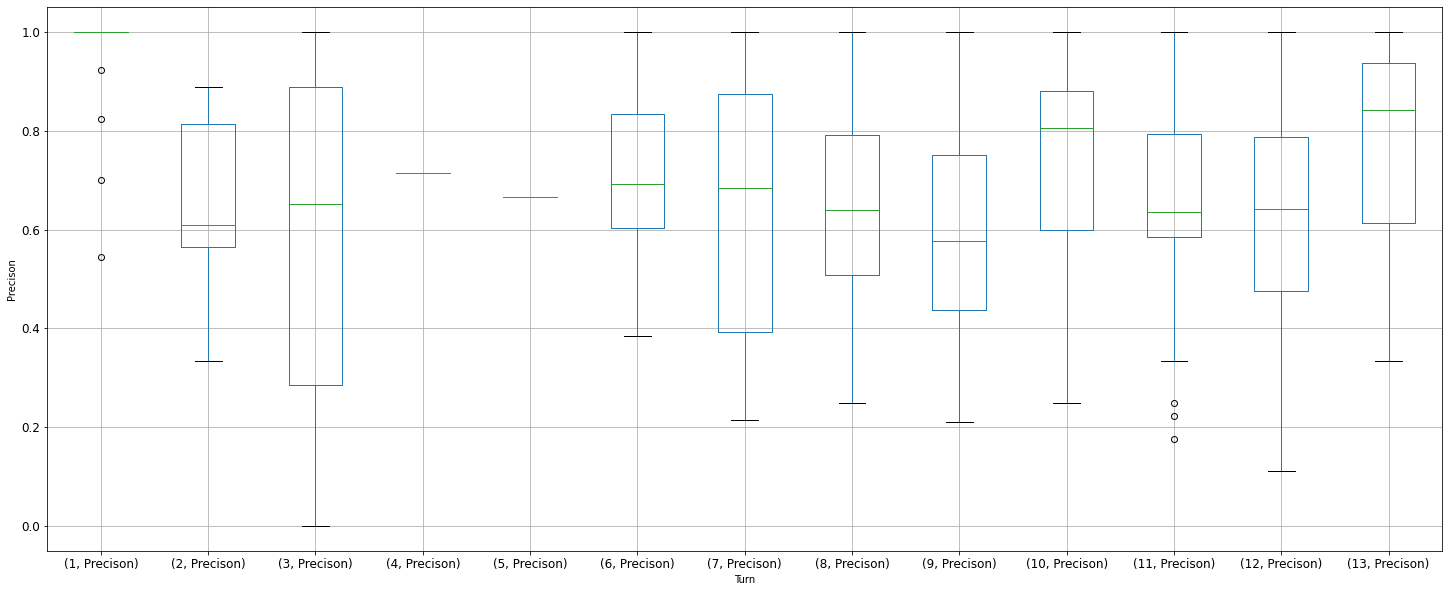

In [59]:
#boxplots for turns
import matplotlib.pyplot as plt
#calculate sum of points for each team
rogue_L_precison = rogueL_raw_utterances[['Precison','ID']]
df_groups = rogue_L_precison.groupby(['ID'])
#create bar plot with custom aesthetics
df_groups.boxplot(rot=45, fontsize=12, figsize=(25,10),subplots=False)  
#rotate x-axis ticks vertically
x = [1, 10,11,12,13,2,3,4,5,6,7,8,9]
plt.xticks(x,rotation=0)
plt.xlabel('Turn')
plt.ylabel('Precison')
plt.show()

## Building the system

In [60]:
# install dependencies
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=491d919f1e3a755e5e8dcad7ed7a282621631203374d1a103962eb32c07a25c5
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [61]:
from sentence_transformers import CrossEncoder

# load cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [62]:
def rank_passages_cross_encoder(rewrite: str, passages: list, cross_encoder: CrossEncoder) -> list:
  """
  Uses a cross encoder to compute the similarity between a query rewrite and a list of
  passages
  """
  query_passage_pairs = [[rewrite, passage['body']] for passage in passages]
  cross_scores = cross_encoder.predict(query_passage_pairs)

  for passage, score in zip(passages, cross_scores):
    passage['score'] = score
  
  ranked_passages = sorted(passages, key=lambda x: x['score'], reverse=True)
  return ranked_passages

In [63]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
#tokenizer = AutoTokenizer.from_pretrained('castorini/monot5-base-msmarco-10k')
ranker = AutoModelForSeq2SeqLM.from_pretrained('castorini/monot5-base-msmarco-10k', return_dict=True).to(device).eval()

In [77]:
#collecting all packages from the candidate documents
def collect_passages(hits: list) -> dict:
  """
  Extracts and collects all passages from candidate documents
  """
  all_passages = []
  for hit in hits:
    doc_id = hit.docid
    document = sparse_searcher.doc(doc_id)
    print(document)
    passages = json.loads(document.raw())['passage_splits']
    for passage in passages:
        passage['id'] = f"{doc_id}-{passage['id']}" 
    all_passages.extend(passages)

  return all_passages

In [65]:
## Encapsulating  the components into a class BASECAsTSystem as defined in TREC CAsT Tools
from abc import ABC, abstractmethod

class BaseCAsTSystem(ABC):
  @abstractmethod
  def retrieve_docments(self, query: str) -> list:
    pass

  @abstractmethod
  def rank_passages(self, query: str, passages: list) -> list:
    pass

In [66]:
#Buidling the cast system
class SimpleCAsTSystem(BaseCAsTSystem):

  def __init__(self, search_system, passage_ranker, device) -> None:

    self.search_system = search_system
    self.passage_ranker = passage_ranker
    self.device = device
  
  
  def retrieve_docments(self, query: str) -> list:
    """
    Simple CAsT System Document Retriever
    """
    hits = self.search_system.search(query)
    return hits
  
  def rank_passages(self, query: str, passages: list) -> list:
    """
    Simple CAsT System Passage Ranker
    """
    query_passage_pairs = [[query, passage['body']] for passage in passages]
    query_passage_scores = self.passage_ranker.predict(query_passage_pairs)

    for passage, score in zip(passages, query_passage_scores):
      passage['score'] = score
    
    ranked_passages = sorted(passages, key=lambda x: x['score'], reverse=True)
    return ranked_passages

In [67]:
# create system instance
simple_cast_system = SimpleCAsTSystem(
    
    search_system=sparse_searcher,
    passage_ranker=cross_encoder,
    device=device
)

In [83]:
#Display format of the results
for topic in topics[8:9]:
  for turn in topic['turn']:
    # get turn id
    turn_id = f"{topic['number']}_{turn['number']}"
    # Build rewriter input -- not ideal, but saves having to write logic again
    query_and_context = build_context(topics, turn_id)
    # rewrite query
    rewrite = answer("canard context: " + query_and_context)
    # retrieve candidate documents
    candidate_documents = simple_cast_system.retrieve_docments(rewrite)
    # collect passages from candidate documents
    extracted_passages = collect_passages(candidate_documents)
    # rank passages
    ranked_passages = simple_cast_system.rank_passages(rewrite, extracted_passages)
    # print output
    print(f"Turn ID: {turn_id}")
    print(f"Query: {turn['raw_utterance']}")
    print(f"Rewrite: {rewrite}")
    print(f"Manual Rewrite: {turn['manual_rewritten_utterance']}")
    print("\n")
    print("Top Passages:")
    for passage in ranked_passages[:3]:
      print(f"Passage ID: {passage['id']}")
      print(f"Score {passage['score']}")
      print(f"Text: {passage['body']}")
      print("\n")
    print("------------------")



Turn ID: 114_1
Query: I’m a runner and I’ve been feeling tired. My doctor said my ferritin count is slightly low. What should I do next?
Rewrite: I’m a runner and I’ve been feeling tired. My doctor said my ferritin count is slightly low. What should I do next?
Manual Rewrite: I’m a runner and I’ve been feeling tired. My doctor said my ferritin count is slightly low. What should I do next?


Top Passages:
Passage ID: MARCO_D1318858-1318858
Score -0.8737022280693054
Text: "ironakafe How long after consistently taking iron pills should I see improvement? 2/17/2012 5:56PMReply Return to Index Report Post My coach thinks there's a possibility that I have low ferritin levels. I'm curious how long it would take to start feeling better and running better once I start taking them every day?orrrrrr RE: How long after consistently taking iron pills should I see improvement?2/17/2012 6:05PM - in reply to ironakafe Reply Return to Index Report Post6 weeks - 3 months THE Iron Man RE: How long after 

In [ ]:
from tqdm import tqdm

with open("files/simple_cast_system_automatic.run", "a") as run_file:
  for topic in tqdm(topics):
    for turn in topic['turn']:
      # get turn id
      turn_id = f"{topic['number']}_{turn['number']}"
      # Build rewriter input -- not ideal, but saves having to write logic again
      query_and_context = build_context(topics, turn_id)
      # rewrite query
      rewrite = answer("canard context: " + query_and_context)
      # retrieve candidate documents
      candidate_documents = simple_cast_system.retrieve_docments(rewrite)
      print(candidate_documents)
      # collect passages from candidate documents
      extracted_passages = collect_passages(candidate_documents)
      # rank passages
      ranked_passages = simple_cast_system.rank_passages(rewrite, extracted_passages)
      # Write output to run file
      for rank, passage in enumerate(ranked_passages):
        run_file.write(f"{turn_id}\tQ0\t{passage['id']}\t{rank+1}\t{passage['score']}\tsimple-cast-system\n")
      # print(f"Wrote passage rankings for Turn {turn_id} to file")

  0%|          | 0/26 [00:00<?, ?it/s]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754ad0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd798c70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7549b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa8 at 0x7fa6bd7566d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb0 at 0x7fa6bd7566f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754bf0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd7566b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754c50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd756690>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754cb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd79a9f0>>, <io.anserini.search.SimpleSearcher$Result at 

  4%|▍         | 1/26 [14:22<5:59:25, 862.62s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd77a090>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754b30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd777f30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd754b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd777c30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd779050 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd777e50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7790b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd777e30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd779110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd7758f0>>, <io.anserini.search.SimpleSearcher$Result at 

  8%|▊         | 2/26 [22:28<4:16:22, 640.93s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd728a10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa87a5b66b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd728e30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd71b450>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd728650 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd71b670>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd728dd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd71b650>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7289b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd71b630>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd728c50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd7311d0>>, <io.anserini.search.SimpleSearcher$Result at 

 12%|█▏        | 3/26 [32:36<4:00:00, 626.11s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734ad0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f08 at 0x7fa6bd761410>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7345f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd73e3b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734290 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd721c50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734410 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd72a910>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734950 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd72a8f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6ffcb0>>, <io.anserini.search.SimpleSearcher$Result at 

 15%|█▌        | 4/26 [36:26<2:52:07, 469.42s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734650 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd712cd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7345f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd707390>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734050 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd707190>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734cb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd707170>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd7344d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd7071b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd734a70 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd72a790>>, <io.anserini.search.SimpleSearcher$Result at 

 19%|█▉        | 5/26 [44:10<2:43:42, 467.75s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73a590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd70f270>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73abf0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd710e30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73ab90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd710e10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73ac50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd710df0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73acb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd710dd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73ad10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd70e550>>, <io.anserini.search.SimpleSearcher$Result at 

 23%|██▎       | 6/26 [55:15<2:58:11, 534.57s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a21d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd696b10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd69d9f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2bf0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd69d9d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2350 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd69d9b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2b30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd69d990>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd693370>>, <io.anserini.search.SimpleSearcher$Result at 

 27%|██▋       | 7/26 [1:02:18<2:37:49, 498.38s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697e30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f08 at 0x7fa6bd6b9710>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697fb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd6afc50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697410 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6afe70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697770 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6afe50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697ef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6afe30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd6b9b50>>, <io.anserini.search.SimpleSearcher$Result at 

 31%|███       | 8/26 [1:08:05<2:15:02, 450.16s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73a590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd6b9890>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73ac50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd6a90d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73a9b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd68fe10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd73acb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd69ee70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a29b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd69ee50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2230 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd68aa50>>, <io.anserini.search.SimpleSearcher$Result at 

 35%|███▍      | 9/26 [1:13:53<1:58:25, 417.98s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2770 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f08 at 0x7fa6bd69c1f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2a10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd6be910>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd683c10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2890 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6a4410>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a2410 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd6a43f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a29b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd6a1090>>, <io.anserini.search.SimpleSearcher$Result at 

 38%|███▊      | 10/26 [1:21:29<1:54:36, 429.79s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6fb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6db170>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6bf0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6f4490>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a67d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6f4390>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6950 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd6f4290>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6c50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd6f4090>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6470 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa8 at 0x7fa6bd6f9eb0>>, <io.anserini.search.SimpleSearcher$Result at 

 42%|████▏     | 11/26 [1:25:28<1:32:51, 371.45s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6dd470 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6eef90>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6ddef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6cb270>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6dd5f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6fa0d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6dd7d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd6c0890>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6ddb90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd6c0870>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6dddd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa8 at 0x7fa6bd694ed0>>, <io.anserini.search.SimpleSearcher$Result at 

 46%|████▌     | 12/26 [1:30:59<1:23:46, 359.02s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697230 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6e9ed0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6970b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6eb590>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697ef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6e57d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6973b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd6deb50>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6978f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd6deb30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd697290 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa8 at 0x7fa6bd6d51b0>>, <io.anserini.search.SimpleSearcher$Result at 

 50%|█████     | 13/26 [1:35:07<1:10:33, 325.62s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f08 at 0x7fa6bd6ea030>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6df310>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680650 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6bf3f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680ef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd6e44d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6802f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f98 at 0x7fa6bd6e44b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680050 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fa0 at 0x7fa6bd6cc970>>, <io.anserini.search.SimpleSearcher$Result at 

 54%|█████▍    | 14/26 [1:39:22<1:00:49, 304.16s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd6d1db0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7890 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd6ca8f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7dd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd6ca4b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7ef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd6ca770>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a78f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6ca7d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd6f0970>>, <io.anserini.search.SimpleSearcher$Result at 

 58%|█████▊    | 15/26 [1:41:36<46:21, 252.84s/it]  

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd6e6850>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680890 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd6f6af0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd680470 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd6f6ad0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a72f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6f6ab0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7dd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd6f6a90>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a7b30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd6d3e90>>, <io.anserini.search.SimpleSearcher$Result at 

 62%|██████▏   | 16/26 [1:45:53<42:20, 254.02s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6950 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd659390>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a62f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd641f30>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6410 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd641110>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6fb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd641050>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6a6710 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd641130>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6dd530 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd6593f0>>, <io.anserini.search.SimpleSearcher$Result at 

 65%|██████▌   | 17/26 [1:49:15<35:45, 238.36s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ed70 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd6730b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66eef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd663f10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66e5f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd663dd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ecb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd64df90>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ee30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd64df70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66e1d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd673c50>>, <io.anserini.search.SimpleSearcher$Result at 

 69%|██████▉   | 18/26 [1:52:48<30:46, 230.85s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ed70 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd67e9f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66e5f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd670490>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ea10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd6706b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66e290 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd670690>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66eef0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd670670>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd66ee30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd62e070>>, <io.anserini.search.SimpleSearcher$Result at 

 73%|███████▎  | 19/26 [1:57:09<27:59, 239.97s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd65cf90>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661ad0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd65b670>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661e30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd65b270>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661530 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd65b590>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6618f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd65b570>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6613b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd664130>>, <io.anserini.search.SimpleSearcher$Result at 

 77%|███████▋  | 20/26 [1:58:34<19:21, 193.50s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd65be70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c86b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd654cb0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c81d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6549b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8a70 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd654bd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8830 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd654bb0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8230 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd65c170>>, <io.anserini.search.SimpleSearcher$Result at 

 81%|████████  | 21/26 [2:01:05<15:02, 180.59s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661a10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd676950>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6615f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd66bb70>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661fb0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd67c150>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6614d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd67c290>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd67c3b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd661c50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd654b90>>, <io.anserini.search.SimpleSearcher$Result at 

 85%|████████▍ | 22/26 [2:04:07<12:03, 180.99s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd6604d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6537d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd679510>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653650 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6795f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd6795d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6539b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd6795b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653590 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd642130>>, <io.anserini.search.SimpleSearcher$Result at 

 88%|████████▊ | 23/26 [2:08:24<10:11, 203.95s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653b90 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd640250>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6538f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd640290>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653dd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd6400d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653470 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd6604d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653710 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd672fd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd653950 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd640970>>, <io.anserini.search.SimpleSearcher$Result at 

 92%|█████████▏| 24/26 [2:11:13<06:26, 193.48s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bb110 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd60d990>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bbf50 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd60f090>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bba10 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd60fdd0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bbe30 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd635b10>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bbdd0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd635af0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6bb290 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd640cb0>>, <io.anserini.search.SimpleSearcher$Result at 

 96%|█████████▌| 25/26 [2:13:55<03:03, 183.89s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c80b0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fb8 at 0x7fa6bd67eaf0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c87d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc0 at 0x7fa6bd615710>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8770 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fc8 at 0x7fa6bd638930>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8170 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe0 at 0x7fa6bd620590>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8230 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25fe8 at 0x7fa6bd620570>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6c8a70 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25ff8 at 0x7fa6bd640cb0>>, <io.anserini.search.SimpleSearcher$Result at 

100%|██████████| 26/26 [2:17:26<00:00, 317.19s/it]

[<io.anserini.search.SimpleSearcher$Result at 0x7fa6bd656770 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f18 at 0x7fa6bd635970>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6562f0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f28 at 0x7fa6bd63d210>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd656050 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f30 at 0x7fa6bd62f7f0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd656470 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f48 at 0x7fa6bd6249d0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd656ad0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f50 at 0x7fa6bd6249b0>>, <io.anserini.search.SimpleSearcher$Result at 0x7fa6bd6567d0 jclass=io/anserini/search/SimpleSearcher$Result jself=<LocalRef obj=0x4a25f90 at 0x7fa6bd640cb0>>, <io.anserini.search.SimpleSearcher$Result at 

In [ ]:
files.download('files/simple_cast_system_automatic.run')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Year 3 relevance judgements contain document ranking, so need to deduplicate run
def deduplicate_run(run_file: str) -> list:

    # {'106_1': [], '106_2' : [], ... }
    document_ids = {}

    with open(run_file) as f:
        run_rows: list = []

        for line in f:
            line_dict: dict = {}
            line_content = line.split()
            line_content[2] = line_content[2].rsplit("-",1)[0]

            # check if turn_id is in the dictionary
            if document_ids.get(line_content[0]):
                # check if turn has document id in its list
                if line_content[2] not in document_ids[line_content[0]]:
                    document_ids[line_content[0]].append(line_content[2])

                    line_dict = {
                        "turn_id": line_content[0],
                        "dummy_value": line_content[1],
                        "doc_id": line_content[2],
                        "rank": line_content[3],
                        "score": line_content[4],
                        "run_name": line_content[5]
                    }
                    run_rows.append(line_dict)
            else:
                document_ids[line_content[0]] = []
                document_ids[line_content[0]].append(line_content[2])

                line_dict = {
                    "turn_id": line_content[0],
                    "dummy_value": line_content[1],
                    "doc_id": line_content[2],
                    "rank": line_content[3],
                    "score": line_content[4],
                    "run_name": line_content[5]
                }
                run_rows.append(line_dict)

        return run_rows


def adjust_run_ranking(run_rows: list) -> list:

    for i in range(1, len(run_rows)):
        if run_rows[i]["turn_id"] == run_rows[i-1]["turn_id"]:
            run_rows[i]["rank"] = str(int(run_rows[i-1]["rank"]) + 1)
        else:
            run_rows[i]['rank'] = str(1)

    return run_rows

In [ ]:
deduplicated_run = deduplicate_run("simple_cast_system context_update .run")
adjusted_run = adjust_run_ranking(deduplicated_run)

with open(f"simple_cast_system_automatic_deduped.run", "w") as deduped_run_file:
    for row in adjusted_run:
        deduped_run_file.write(
            f'{row["turn_id"]} {row["dummy_value"]} {row["doc_id"]} {row["rank"]} {row["score"]} {row["run_name"]}\n')

In [ ]:
!git clone https://github.com/usnistgov/trec_eval.git
%cd trec_eval
!make
!mv trec_eval /usr/local/bin/
%cd ..

fatal: destination path 'trec_eval' already exists and is not an empty directory.
/content/trec_eval
gcc -g -I.  -Wall -DVERSIONID=\"9.0.7\"  -o trec_eval trec_eval.c formats.c meas_init.c meas_acc.c meas_avg.c meas_print_single.c meas_print_final.c get_qrels.c get_trec_results.c get_prefs.c get_qrels_prefs.c get_qrels_jg.c form_res_rels.c form_res_rels_jg.c form_prefs_counts.c utility_pool.c get_zscores.c convert_zscores.c measures.c  m_map.c m_P.c m_num_q.c m_num_ret.c m_num_rel.c m_num_rel_ret.c m_gm_map.c m_Rprec.c m_recip_rank.c m_bpref.c m_iprec_at_recall.c m_recall.c m_Rprec_mult.c m_utility.c m_11pt_avg.c m_ndcg.c m_ndcg_cut.c m_Rndcg.c m_ndcg_rel.c m_binG.c m_G.c m_rel_P.c m_success.c m_infap.c m_map_cut.c m_gm_bpref.c m_runid.c m_relstring.c m_set_P.c m_set_recall.c m_set_rel_P.c m_set_map.c m_set_F.c m_num_nonrel_judged_ret.c m_prefs_num_prefs_poss.c m_prefs_num_prefs_ful.c m_prefs_num_prefs_ful_ret.c m_prefs_simp.c m_prefs_pair.c m_prefs_avgjg.c m_prefs_avgjg_Rnonrel.c m_pr

In [ ]:
!echo "Downloading Year 3 relevance judgements.."
!wget -c https://raw.githubusercontent.com/daltonj/treccastweb/master/2021/trec-cast-qrels-docs.2021.qrel -P files

--2022-09-06 00:30:57--  https://raw.githubusercontent.com/daltonj/treccastweb/master/2021/trec-cast-qrels-docs.2021.qrel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 507215 (495K) [text/plain]
Saving to: ‘files/trec-cast-qrels-docs.2021.qrel’

trec-cast-qrels-doc 100%[===================>] 495.33K  --.-KB/s    in 0.04s   

2022-09-06 00:30:57 (13.5 MB/s) - ‘files/trec-cast-qrels-docs.2021.qrel’ saved [507215/507215]



In [ ]:
#checking NDCG@3 scores.
!trec_eval -q -m ndcg files/trec-cast-qrels-docs.2021.qrel simple_cast_system_automatic_deduped.run

ndcg                  	106_1	0.0794
ndcg                  	106_10	0.0000
ndcg                  	106_2	0.1811
ndcg                  	106_3	0.1767
ndcg                  	106_4	0.4702
ndcg                  	106_5	0.3708
ndcg                  	106_6	0.3740
ndcg                  	106_7	0.5500
ndcg                  	106_8	0.1251
ndcg                  	107_1	0.1009
ndcg                  	107_2	0.2836
ndcg                  	107_3	0.4029
ndcg                  	107_4	0.2957
ndcg                  	107_5	0.3392
ndcg                  	107_6	0.2635
ndcg                  	107_7	0.3041
ndcg                  	107_8	0.2984
ndcg                  	108_1	0.2594
ndcg                  	108_2	0.2212
ndcg                  	108_3	0.1810
ndcg                  	108_4	0.0375
ndcg                  	108_5	0.2283
ndcg                  	108_6	0.0337
ndcg                  	108_7	0.2038
ndcg                  	108_8	0.1054
ndcg                  	110_1	0.3255
ndcg                  	110_2	0.2180
ndcg                  	110_

In [ ]:
#The above results are copied and stored in NCCG update scores which is then uploaded to colab folder structure

In [ ]:
#reading the updated CSV file
import pandas as pd
df_update = pd.read_csv('NDCG update scores.csv', names=["Topic ID", "Score"])
df_update

,Topic ID,Score
0,106_1,0.0794
1,106_10,0.0000
2,106_2,0.1811
3,106_3,0.1767
4,106_4,0.4702
...,...,...
154,131_6,0.1240
155,131_7,0.1668
156,131_8,0.2276
157,131_9,0.0442


In [ ]:
#Splitting the topic file
df_update["Topic"]= df_update['Topic ID'].str.split('_',n=-1, expand=True)[0]

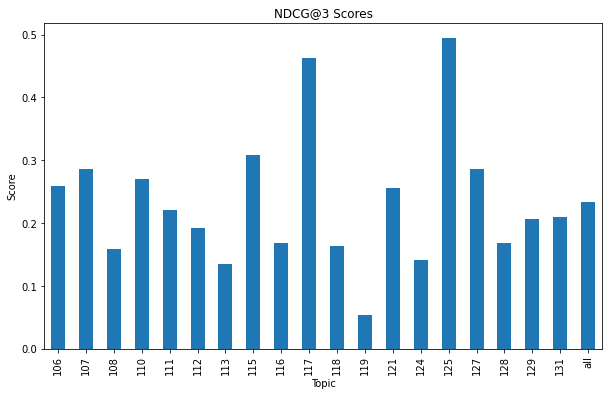

In [ ]:
#barplot of average ndcg score per topic file
import matplotlib.pyplot as plt
df_groups = df_update.groupby(['Topic'])['Score'].mean()
df_groups.plot(kind='bar', title='NDCG@3 Scores',
               ylabel='Score', xlabel='Topic', figsize=(10, 6))
plt.show()

FileNotFoundError: ignored